In [ ]:
%pip install datasets evaluate --upgrade

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import tqdm
import evaluate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# Make CUDA operations deterministic
torch.backends.cudnn.deterministic = True
!python -c "import torch; print(torch.cuda.is_available())"

True


In [7]:
dataset = datasets.load_dataset("bentrevett/multi30k")

In [8]:
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

In [9]:
# For better visualization using pandas
import pandas as pd

# Display sample of training datasets
print("Training Sample:")
print("==============")
print("\nFirst 5 training examples:")
print(dataset['train'][:5])

print("\nTranining Dataset Statistics:")
print("=================")
print(f"Number of examples: {len(dataset['train'])}")

# Convert first few examples to pandas DataFrame
df = pd.DataFrame(dataset['train'][:5])
print("\nSample Training Data:")
print("=======================")
display(df)

Training Sample:

First 5 training examples:
{'en': ['Two young, White males are outside near many bushes.', 'Several men in hard hats are operating a giant pulley system.', 'A little girl climbing into a wooden playhouse.', 'A man in a blue shirt is standing on a ladder cleaning a window.', 'Two men are at the stove preparing food.'], 'de': ['Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.', 'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.', 'Ein kleines Mädchen klettert in ein Spielhaus aus Holz.', 'Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster.', 'Zwei Männer stehen am Herd und bereiten Essen zu.']}

Tranining Dataset Statistics:
Number of examples: 29000

Sample Training Data:


,en,de
0,"Two young, White males are outside near many b...",Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


In [10]:
import spacy
  # Load spaCy models
try:
    en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
    de_nlp = spacy.load('de_core_news_sm', disable=['parser', 'tagger', 'ner'])
except OSError:
    # Download if not present
    import os
    os.system('python -m spacy download en_core_web_sm')
    os.system('python -m spacy download de_core_news_sm')
    en_nlp = spacy.load('en_core_web_sm', disable=['parser', 'tagger', 'ner'])
    de_nlp = spacy.load('de_core_news_sm', disable=['parser', 'tagger', 'ner'])

In [11]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [12]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [13]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 8897.79 examples/s]


### Vocabularies

Next, we'll build the _vocabulary_ for the source and target languages. The vocabulary is used to associate each unique token in our dataset with an index (an integer), e.g. "hello" = 1, "world" = 2, "bye" = 3, "hates" = 4, etc. When feeding text data to our model, we convert the string into tokens and then the tokens into numbers using the vocabulary as a look up table, e.g. "hello world" becomes `["hello", "world"]` which becomes `[1, 2]` using the example indices given. We do this as neural networks cannot operate on strings, only numerical values.

We create the vocabulary (one for each language) from our datasets using the `build_vocab_from_parallel_data` function, provided by customized Vocabulary class, built on spacY, which accepts an iterator where each item is a list of tokens. It then counts up the number of unique tokens and assigns each a numerical value.

In theory, our vocabulary can be large enough to have an index for every unique token in our dataset. However, what happens if a token exists in our validation and test set, but not in our training set? In that case, we replace the token with an "unknown token", denoted by `<unk>`, which is given its own index (usually index zero). All unknown tokens are replaced by `<unk>`, even if the tokens are different, i.e. if the tokens "gilgamesh" and "enkidu" were both not within our vocabulary, then the string "gilgamesh hates enkidu" gets tokenized to `["gilgamesh", "hates", "enkidu"]` and then becomes `[0, 24, 0]` (where "hates" has the index 24).

Ideally, we want our model to be able to handle unknown tokens by learning to use the context around them to make translations. The only way it can learn that is if we also have unknown tokens in the training set. Hence, when creating our vocabularies with `build_vocab_from_parallel_data`, we use the `min_freq` argument to not create an index for tokens which appear less than `min_freq` times in our training set. In other words, when using the vocabulary, any token which does not appear at least twice in our training set will get replaced by the unknown token index when converting tokens to indices.

It is important to note that a vocabulary should only be built from the training set and never the validation or test set. This prevents "information leakage" into our model, giving us artifically inflated validation/test scores.

We also use the `specials` argument of `build_vocab_from_parallel_data` to pass _special tokens_. These are tokens which we want to add to the vocabulary but do not necessarily appear in our tokenized examples. These special tokens will appear first in the vocabulary. We've already discussed the `unk_token`, `sos_token`, and `eos_token`. The final special token is the `pad_token`, denoted by `<pad>`.

When inputting sentences into our model, it is more efficient to pass multiple sentences at once (known as a batch), instead of one at a time. The requirement for sentences to be batched together is that they all have to be the same length (in terms of the number of tokens). The majority of our sentences are not the same length, but we can solve this by "padding" (adding `<pad>` tokens) the tokenized version of each sentence in a batch until they all have equal tokens to the longest sentence in the batch. For example, if we had two sentences: "I love pizza" and "I hate music videos". They would be tokenized to something like: `["i", "love", "pizza"]` and `["i", "hate", "music", "videos"]`. The first sequence of tokens would then be padded to `["i", "love", "pizza", "<pad>"]`. Both sequences could then be converted to indexes using the vocabulary.

We'll handle the padding and batching later.

In [15]:
from collections import Counter
from typing import List, Dict

# Assume the input data is always lowercased, so we have better performance
# with vocabulary lookup
class Vocabulary:
    def __init__(self, tokens_to_index):
        self.tokens_to_index = tokens_to_index
        self.index_to_tokens = {v: k for k, v in tokens_to_index.items()}
        self.default_index = None
    
    def __getitem__(self, token):
        """Retrieve index of token"""
        return self.tokens_to_index.get(token, self.default_index)
    
    # We can run `"the" in en_vocab` to check if a token is in the vocabulary
    def __contains__(self, token):
        """Enable membership testing with 'in' operator"""
        return (token in self.tokens_to_index)
    
    def set_default_index(self, index):
        self.default_index = index
        
    def lookup_indices(self, tokens):
        """Convert a list of tokens to indices"""
        return [self.tokens_to_index.get(token, self.default_index) for token in tokens]
    
    def lookup_tokens(self, indices):
        """Convert a list of indices back to tokens"""
        return [self.index_to_tokens.get(idx, self.index_to_tokens[self.default_index]) 
                for idx in indices]
    
    def __len__(self):
        return len(self.tokens_to_index)

def build_vocab_from_parallel_data(data_iterator: List[Dict], 
                                 min_freq: int = 2, 
                                 specials: List[str] = ["<unk>", "<pad>", "<sos>", "<eos>"]):
    """Build vocabularies from parallel tokenized data using spaCy"""
    en_counter = Counter()
    de_counter = Counter()
    
    for item in data_iterator:
        en_tokens = [token.text.lower() for token in en_nlp(item['en'])]
        de_tokens = [token.text.lower() for token in de_nlp(item['de'])]
        en_counter.update(en_tokens)
        de_counter.update(de_tokens)
    
    def create_vocab(counter):
        tokens_to_index = {}
        for i, token in enumerate(specials):
            tokens_to_index[token] = i
        
        idx = len(specials)
        for token, count in counter.most_common():
            if count >= min_freq and token not in tokens_to_index:
                tokens_to_index[token] = idx
                idx += 1
                
        vocab = Vocabulary(tokens_to_index)
        vocab.set_default_index(tokens_to_index["<unk>"])
        return vocab
    
    en_vocab = create_vocab(en_counter)
    de_vocab = create_vocab(de_counter)
    
    return en_vocab, de_vocab

Now, we can build both `en_vocab` and `de_vocab` in parallel, given the dataset

In [17]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_vocab, de_vocab = build_vocab_from_parallel_data(train_data, min_freq=min_freq, specials=special_tokens)

In [18]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [19]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

In [21]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [22]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Map: 100%|██████████| 1000/1000 [00:00<00:00, 20087.47 examples/s]


In [23]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, columns=format_columns, output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [28]:
from typing import Callable, Dict, List, Any

def get_collate_fn(pad_index: int) -> Callable[[List[Dict[str, Any]]], Dict[str, torch.Tensor]]:
    def collate_fn(batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch

    return collate_fn

In [30]:
from typing import Any
from torch.utils.data import DataLoader, Dataset

def get_data_loader(dataset: Dataset, batch_size: int, pad_index: int, shuffle: bool = False) -> DataLoader:
    collate_fn = get_collate_fn(pad_index)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [31]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [34]:
from torch import Tensor
from typing import Tuple

# Bi-directional GRU Encoder
class Encoder(nn.Module):
    def __init__(
        self,
        input_dim: int,
        embedding_dim: int,
        encoder_hidden_dim: int,
        decoder_hidden_dim: int,
        dropout: float
    ):
        super().__init__()
        # shape = [input_dim, embedding_dim], there are input_dim number of tokens
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # shape = [embedding_dim, encoder_hidden_dim], there are embedding_dim number of features
        # bidirectional=True: process sequence in both directions
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)

        # encoder_hidden_dim * 2: bidirectional concatenated states
        # decoder_hidden_dim: match decoder dimensions
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)

        # # dropout=0.5 means 50% elements zeroed
        self.dropout = nn.Dropout(dropout)

    # embedded [L,B,E] → GRU → (outputs [L,B,H*2], hidden [2,B,H])
    # where:
    # L = sequence length
    # B = batch size
    # E = embedding dim
    # H = hidden dim
    def forward(self, src: Tensor) -> Tuple[Tensor, Tensor]:
        # src = [len(src), batch size]
        # During training: dropout randomly zeroes some of the elements of the input tensor
        embedded = self.dropout(self.embedding(src))
        # embedded = [len(src), batch_size, embedding_dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [len(src), batch_size, hidden_dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden_dim]
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer

        # Step 1: Extract forward and backward states
        hidden_forward = hidden[-2, :, :]   # Shape: [batch_size, hidden_dim]
        hidden_backward = hidden[-1, :, :]  # Shape: [batch_size, hidden_dim]

        # Step 2: Concatenate states
        # concatenated: [batch_size, hidden_dim * 2]
        concatenated = torch.cat(
            (hidden_forward, hidden_backward),  
            dim=1
        )

        # Step 3: Linear transformation
        # linear_output: [batch_size, decoder_hidden_dim]
        linear_output = self.fc(concatenated)

        # Step 4: Apply tanh activation, to retrieve hidden state, Output range: (-1, 1)
        # outputs are always from the last layer
        # outputs = [len(src), batch_size, encoder_hidden_dim * 2]
        # hidden = [batch_size, decoder_hidden_dim]
        hidden = torch.tanh(linear_output)
        return outputs, hidden

In [36]:
"""
Attention Layer, Feed-forward neural network with a single hidden layer
Softmax activation function is applied to the output layer
https://www.udemy.com/course/complete-generative-ai-course-with-langchain-and-huggingface/learn/lecture/44687487#overview
"""
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim: int, decoder_hidden_dim: int) -> None:
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src_length, batch_size, encoder_hidden_dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        # repeat decoder hidden state src_length times

        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        # hidden = [batch_size, src_length, decoder_hidden_dim]

        # [0,1,2] as [src_length, batch_size, encoder_hidden_dim * 2] 
        # → [1,0,2] as [batch_size, src_length, encoder_hidden_dim * 2]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]

        # Step 1: Concatenate hidden state and encoder outputs. This is called energy
        concatenated = torch.cat((hidden, encoder_outputs), dim=2)

        # Step 2: After concat hidden with encorder_outputs, we have attentions, now activate it
        energy = torch.tanh(self.attn_fc(concatenated))
        # energy = [batch size, src length, decoder hidden dim]

        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)

In [37]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [39]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [40]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [41]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [42]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 20,518,405 trainable parameters


In [43]:
optimizer = optim.Adam(model.parameters())

In [44]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [45]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)
        trg = batch["en_ids"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [46]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)
            trg = batch["en_ids"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [47]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut3-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

 10%|█         | 1/10 [00:55<08:19, 55.46s/it]

	Train Loss:   5.015 | Train PPL: 150.726
	Valid Loss:   4.802 | Valid PPL: 121.743


 20%|██        | 2/10 [01:51<07:26, 55.82s/it]

	Train Loss:   4.169 | Train PPL:  64.622
	Valid Loss:   4.396 | Valid PPL:  81.127


 30%|███       | 3/10 [02:48<06:35, 56.47s/it]

	Train Loss:   3.492 | Train PPL:  32.840
	Valid Loss:   3.786 | Valid PPL:  44.078


 40%|████      | 4/10 [03:46<05:40, 56.81s/it]

	Train Loss:   2.953 | Train PPL:  19.158
	Valid Loss:   3.469 | Valid PPL:  32.090


 50%|█████     | 5/10 [04:43<04:44, 56.88s/it]

	Train Loss:   2.561 | Train PPL:  12.947
	Valid Loss:   3.372 | Valid PPL:  29.149


 60%|██████    | 6/10 [05:39<03:46, 56.67s/it]

	Train Loss:   2.252 | Train PPL:   9.511
	Valid Loss:   3.274 | Valid PPL:  26.425


 70%|███████   | 7/10 [06:32<02:46, 55.55s/it]

	Train Loss:   2.022 | Train PPL:   7.555
	Valid Loss:   3.306 | Valid PPL:  27.266


 80%|████████  | 8/10 [07:25<01:49, 54.64s/it]

	Train Loss:   1.794 | Train PPL:   6.013
	Valid Loss:   3.360 | Valid PPL:  28.783


 90%|█████████ | 9/10 [08:18<00:54, 54.09s/it]

	Train Loss:   1.639 | Train PPL:   5.149
	Valid Loss:   3.348 | Valid PPL:  28.446


100%|██████████| 10/10 [09:10<00:00, 55.08s/it]

	Train Loss:   1.493 | Train PPL:   4.451
	Valid Loss:   3.367 | Valid PPL:  29.000


In [48]:
model.load_state_dict(torch.load("tut3-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

/tmp/ipykernel_62356/330183424.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("tut3-model.pt"))


| Test Loss: 3.254 | Test PPL:  25.901 |


In [49]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):
            de_tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            de_tokens = [token for token in sentence]
        if lower:
            de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = de_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]

In [50]:
def plot_attention(sentence, translation, attention):
    fig, ax = plt.subplots(figsize=(10, 10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [51]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [52]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [53]:
translation

['<sos>',
 'a',
 'man',
 'in',
 'an',
 'orange',
 'hat',
 'is',
 'something',
 'something',
 'something',
 '.',
 '<eos>']

In [54]:
sentence_tokens

['<sos>',
 'ein',
 'mann',
 'mit',
 'einem',
 'orangefarbenen',
 'hut',
 ',',
 'der',
 'etwas',
 'anstarrt',
 '.',
 '<eos>']

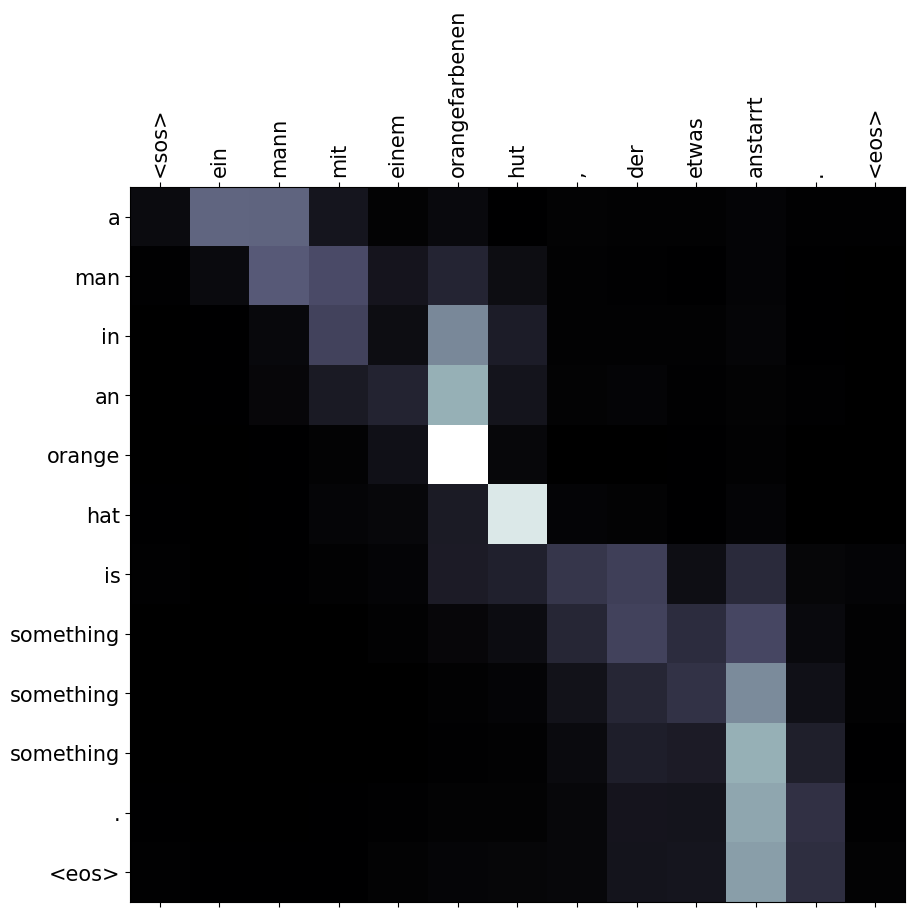

In [55]:
plot_attention(sentence_tokens, translation, attention)

In [56]:
sentence = "Ein Mann sieht sich einen Film an."

In [57]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

In [58]:
translation

['<sos>', 'a', 'man', 'watches', 'a', 'a', 'a', '.', '<eos>']

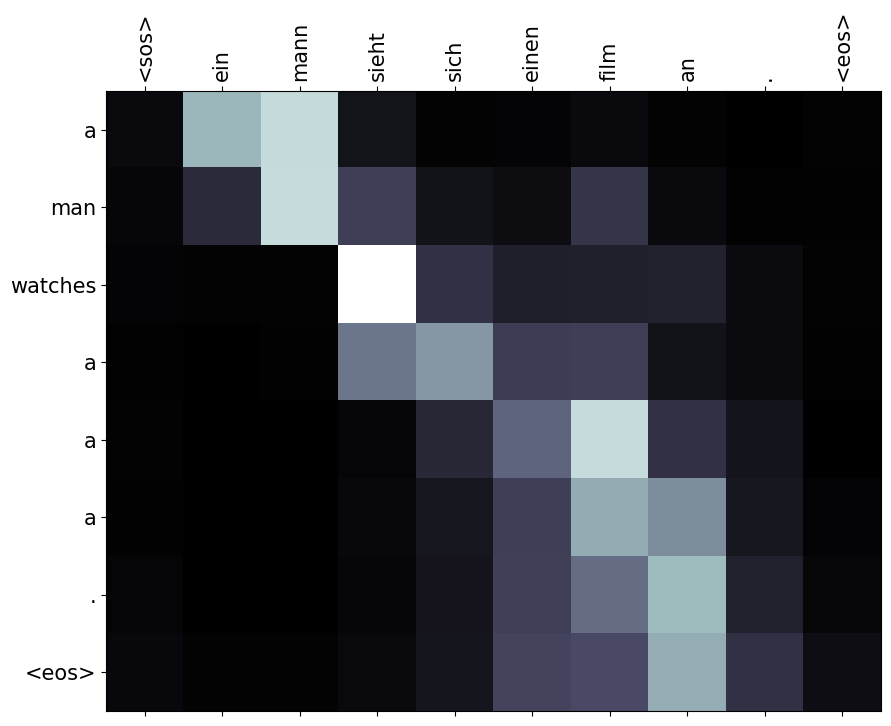

In [59]:
plot_attention(sentence_tokens, translation, attention)

In [60]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )[0]
    for example in tqdm.tqdm(test_data)
]

100%|██████████| 1000/1000 [00:06<00:00, 148.07it/s]


In [61]:
bleu = evaluate.load("bleu")

In [62]:
predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

In [63]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [64]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [65]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

In [47]:
results

{'bleu': 0.2830420566177357,
 'precisions': [0.6118114963229776,
  0.3586727243225702,
  0.21587497792689386,
  0.13548324617470464],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0205238168172768,
 'translation_length': 13326,
 'reference_length': 13058}